In [1]:
from NN import *
from LTL import *


from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import os
from matplotlib import pyplot as plt
import time 

from ipywidgets.widgets import IntSlider
from ipywidgets import interact

Number of Omega-automaton states (including the trap state): 3


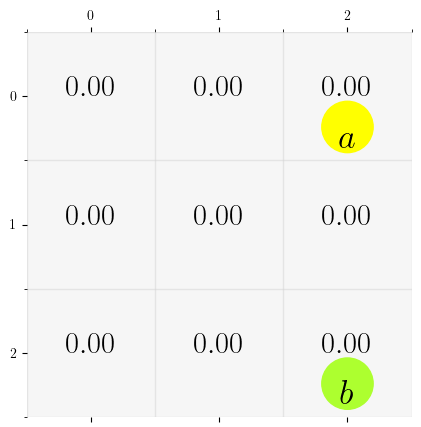

In [2]:
ltl = ("G (F a & F b)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (3,3)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('a',)],
[(),    (),    ()],
[(),(),    ('b',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
p=1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot(save="env.pdf")

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [3]:
t = "[] (<> a /\ <> b)"

LTL_formula = parser.parse(t)
predicates=grid_mdp.get_predicates()
print(predicates)

{'a': [2], 'b': [8]}


In [20]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
# model.summary()

In [21]:
N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()

In [24]:
search_depth = 100
MCTS_samples = 100

num_training_epochs =  1
num_test_epochs = 10
training = True
epochs = 20
T = [25]
K = 1

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                csrl.reward, N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=MCTS_samples, visited=visited, start=(0,0), search_depth=search_depth,
                verbose=0, T=i, K=K)
        # print('N',N[(0,0,0,0)])
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                csrl.reward, N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, visited=set(), start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)

    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

---  0.06000000000000005 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8]
Train wins: 0 / 1
---  0.050000000000000044 : [0, 1, 2, 5, 8, 5, 2, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2]
---  0.050000000000000044 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2]
---  0.06000000000000005 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8]
---  0.050000000000000044 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 8, 5, 2]
---  0.06000000000000005 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8]
---  0.050000000000000044 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 2, 1, 2, 5, 8, 5]
---  0.040000000000000036 : [0, 1, 4, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 2, 5, 8, 5, 2, 5, 8, 7, 4, 5, 2, 5]
---  0.050000000000000044 : [0, 1, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5, 8, 8, 5, 2, 5, 8, 5, 2, 5, 8, 5, 2, 5]
---  0.050000000000000044 : [0, 3, 4, 5, 2, 5, 8,

In [26]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:])
    
t=IntSlider(value=0,min=0,max=T[-1]-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=24), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [9]:
Q=csrl.q_learning(T=100,K=10000)

policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [14]:
for i in episode:
    print(csrl.reward[i])

0.0
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009
0.0
0.0
0.0
0.010000000000000009


In [10]:
episode, rew =csrl.simulate(policy, LTL_formula, predicates, start=(0,0),T=100,plot=True)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…